In [907]:
import numpy as np
import pandas as pd 

# machine learning
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import to_categorical
from keras.optimizers import SGD

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [908]:
train = pd.read_csv("train.csv", index_col='PassengerId')
test = pd.read_csv("test.csv")

In [909]:
train.shape

(891, 11)

In [910]:
# delete index name in order to drop multilevel column names
del train.index.name

In [911]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [912]:
# Name does not contribute to survival, drop it
train = train.drop('Name', axis=1)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,female,35.0,1,0,113803,53.1000,C123,S
5,0,3,male,35.0,0,0,373450,8.0500,NaN,S


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a8fc136a0>]], dtype=object)

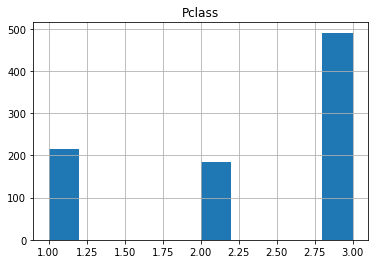

In [913]:
# Check the distribution of Pclass
train.hist(column='Pclass')

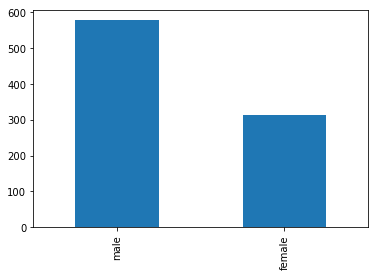

In [914]:
# Check the distribution of Gender
train['Sex'].value_counts().plot(kind='bar')

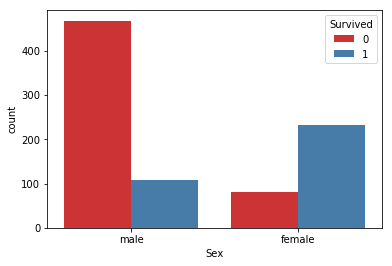

In [915]:
sns.countplot(x='Sex', hue='Survived', data=train, palette='Set1')

In [916]:
def convert_to_dummies(df, column):

    dummies = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1) 
    return df

In [917]:
train = convert_to_dummies(train, 'Sex')
train.head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male
1,0,3,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
2,1,1,38.0,1,0,PC 17599,71.2833,C85,C,1,0
3,1,3,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0
4,1,1,35.0,1,0,113803,53.1000,C123,S,1,0
5,0,3,35.0,0,0,373450,8.0500,NaN,S,0,1


In [918]:
train['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [919]:
train = train.drop('Ticket', axis=1)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Embarked,Sex_female,Sex_male
1,0,3,22.0,1,0,7.2500,NaN,S,0,1
2,1,1,38.0,1,0,71.2833,C85,C,1,0
3,1,3,26.0,0,0,7.9250,NaN,S,1,0
4,1,1,35.0,1,0,53.1000,C123,S,1,0
5,0,3,35.0,0,0,8.0500,NaN,S,0,1


In [920]:
train = train.drop('Cabin', axis=1)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_female,Sex_male
1,0,3,22.0,1,0,7.2500,S,0,1
2,1,1,38.0,1,0,71.2833,C,1,0
3,1,3,26.0,0,0,7.9250,S,1,0
4,1,1,35.0,1,0,53.1000,S,1,0
5,0,3,35.0,0,0,8.0500,S,0,1


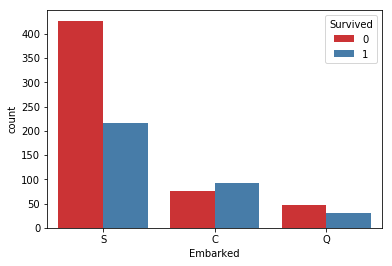

In [921]:
sns.countplot(x='Embarked', hue='Survived', data=train, palette='Set1')

In [922]:
train = convert_to_dummies(train, 'Embarked')
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
1,0,3,22.0,1,0,7.2500,0,1,0,0,1
2,1,1,38.0,1,0,71.2833,1,0,1,0,0
3,1,3,26.0,0,0,7.9250,1,0,0,0,1
4,1,1,35.0,1,0,53.1000,1,0,0,0,1
5,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [923]:
train['Age'] = train['Age'].fillna(train['Age'].mean())
train[['Fare']] = train[['Fare']].fillna(train[['Fare']].mean())

In [924]:
X = train.drop('Survived', axis=1)
y = train['Survived'].values

In [925]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [926]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

In [927]:
X_train.shape, X_test.shape

((712, 10), (179, 10))

### Keras Model

In [928]:
model = Sequential()

In [929]:
model.add(Dense(256, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy'
              , optimizer='rmsprop'
              , metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, batch_size=16)

Epoch 1/20
712/712 [==============================] - 14s 20ms/step - loss: 0.5130 - acc: 0.7837
Epoch 2/20
712/712 [==============================] - 0s 505us/step - loss: 0.4519 - acc: 0.8076
Epoch 3/20
712/712 [==============================] - 0s 504us/step - loss: 0.4422 - acc: 0.8188 0s - loss: 0.4883 - acc: 
Epoch 4/20
712/712 [==============================] - 0s 500us/step - loss: 0.4262 - acc: 0.8301
Epoch 5/20
712/712 [==============================] - 0s 506us/step - loss: 0.4165 - acc: 0.8287
Epoch 6/20
712/712 [==============================] - 0s 498us/step - loss: 0.4072 - acc: 0.8385
Epoch 7/20
712/712 [==============================] - 0s 499us/step - loss: 0.4254 - acc: 0.8202
Epoch 8/20
712/712 [==============================] - 0s 494us/step - loss: 0.4057 - acc: 0.8371
Epoch 9/20
712/712 [==============================] - 0s 504us/step - loss: 0.4172 - acc: 0.8413
Epoch 10/20
712/712 [==============================] - 0s 507us/step - loss: 0.4032 - acc: 0.8399
Epo

In [930]:
score = model.evaluate(X_test, y_test, batch_size=16)

179/179 [==============================] - 6s 34ms/step


In [931]:
score

[0.52948363408363064, 0.82122905027932958]

## GirdSearch

In [932]:
def keras_model(  input_hidden_acti_func='relu'
                       , output_acti_func='sigmoid'
                       , optimizer='rmsprop'
                       , loss='binary_crossentropy'
                       , metrics=['accuracy']
                       , input_hidden_neurons=64
                       , output_neurons=1
                       , input_dim=X.shape[1]):
    
    model = Sequential()
    
    model.add(Dense(input_hidden_neurons, input_dim=input_dim, activation=input_hidden_acti_func))
    
    model.add(Dense(input_hidden_neurons, activation=input_hidden_acti_func))
    # model.add(Dense(Dropout(0.2)))
    # model.add(BatchNormalization())
    
    model.add(Dense(output_neurons, activation=output_acti_func))
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model

In [933]:
untuned_model = KerasClassifier(build_fn=keras_model, verbose=0)

### Create Hyperparameter Search Space

In [934]:
# Create hyperparameter space
epochs = [5, 10]
batch_size = [8, 16, 32]
optimizers = ['rmsprop', 'adam']
# dropout_rate = [0.2, 0.5]
# Create hyperparameter options
hyperparameters = dict(optimizer=optimizers, epochs=epochs, batch_size=batch_size)# , dropout_rate=dropout_rate

### Conduct Gird Search

In [935]:
grid = GridSearchCV(estimator=untuned_model, param_grid=hyperparameters)

grid_result = grid.fit(X, y)

grid_result.best_params_

{'batch_size': 8, 'epochs': 10, 'optimizer': 'rmsprop'}

In [936]:
grid_result.best_score_

0.82828282828282829

In [937]:
best_epochs = grid_result.best_params_['epochs']
best_batch_size = grid_result.best_params_['batch_size']
best_optimizer = grid_result.best_params_['optimizer']

## Use GirdSearch Parameters to Predict

In [938]:
# model_pred = KerasClassifier(build_fn=KC, optimizer=best_optimizer, epochs=best_epochs, batch_size=best_batch_size, verbose=0)
# model_pred.fit(X_train, y_train)

In [939]:
model_after_tuning = KerasClassifier(build_fn=keras_model, optimizer=best_optimizer, epochs=best_epochs, batch_size=best_batch_size, verbose=0)

In [940]:
# model_pred = keras_model(optimizer=best_optimizer)

In [941]:
model_after_tuning.fit(X_train, y_train)

In [942]:
# model_pred.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=0)

In [943]:
predictions = model_after_tuning.predict(X_test)

In [946]:
predictions[:10]

array([[0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1]])

## K Folds

In [944]:
cross_val_score(model_pred, X, y, cv=5)

array([ 0.76536313,  0.8258427 ,  0.8258427 ,  0.7752809 ,  0.88764045])